In [1]:
import os
import pandas as pd
import numpy as np

import cudf
import nvtabular as nvt

In [2]:
DATA_FOLDER = "/workspace/yoochoose-data"
FILENAME_PATTERN = 'yoochoose-clicks.dat'
DATA_PATH = os.path.join(DATA_FOLDER, FILENAME_PATTERN)

!ls $DATA_PATH

/workspace/yoochoose-data/yoochoose-clicks.dat


In [3]:

#Accepted data formats are: csv | tsv | parquet
DATA_FORMAT = 'csv' 
#List of columns names to be used for CSV / TSV files without the header line
HEADLESS_CSV_COLUMN_NAMES = ['session_id','timestamp', 'item_id', 'category']

In [4]:
DATA_FORMAT = 'csv' 
if DATA_FORMAT == 'parquet':
    gdf = cudf.read_parquet(DATA_PATH)
    
elif DATA_FORMAT in ['csv', 'tsv']:
    gdf = cudf.read_csv(DATA_PATH,                              
                             sep='\t' if DATA_FORMAT == 'tsv' else ',',
                             names=HEADLESS_CSV_COLUMN_NAMES
                            )

In [5]:
gdf.head()

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


In [6]:
gdf_grouped = gdf.groupby('item_id').agg({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'itemid_ts_first'})

In [7]:
gdf_grouped.head()

,item_id,itemid_ts_first
0,214858691,2014-09-26T14:50:12.011Z
1,214512459,2014-05-28T19:29:41.227Z
2,214541362,2014-06-05T06:09:33.034Z
3,214843680,2014-04-01T06:04:30.903Z
4,214682154,2014-04-01T09:42:39.407Z


In [8]:
gdf_merged = gdf.merge(gdf_grouped, on=['item_id'], how='left')

In [9]:
gdf_merged.head()

,session_id,timestamp,item_id,category,itemid_ts_first
0,10369,2014-04-01T14:53:56.554Z,214819496,0,2014-04-01T05:51:34.735Z
1,10369,2014-04-01T14:54:25.078Z,214819496,0,2014-04-01T05:51:34.735Z
2,10369,2014-04-01T14:54:25.997Z,214819496,0,2014-04-01T05:51:34.735Z
3,10369,2014-04-01T14:55:10.917Z,214819496,0,2014-04-01T05:51:34.735Z
4,10369,2014-04-01T14:55:11.930Z,214819496,0,2014-04-01T05:51:34.735Z


In [10]:
gdf_merged.shape

(33003944, 5)

In [11]:
# create time features
sessionTime = (
    ['timestamp'] >> 
    nvt.ops.LambdaOp(lambda col: col.astype('datetime64[ms]')) 
)

sessionTime_hour = (
    sessionTime >> 
    (lambda col: cudf.to_datetime(col, unit='ms').dt.hour) >> 
    nvt.ops.Rename(postfix = '_hour')
)
sessionTime_weekday = (
    sessionTime >> 
    (lambda col: cudf.to_datetime(col, unit='ms').dt.weekday) >> 
    nvt.ops.Rename(postfix = '_wd')
)
sessionTime_day = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.day) >> 
    nvt.ops.Rename(postfix="_day")
)
sessionTime_month = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.month) >> 
    nvt.ops.Rename(postfix="_month")
)
sessionTime_year = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.year) >> 
    nvt.ops.Rename(postfix="_year")
)

In [12]:
def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

def get_cycled_feature_value_cos(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_cos = np.cos(2*np.pi*value_scaled)
    return value_cos

In [13]:
hour_sin = sessionTime_hour >> (lambda col: get_cycled_feature_value_sin(col, 24)) >> nvt.ops.Rename(postfix = '_sin')
hour_cos = sessionTime_hour >> (lambda col: get_cycled_feature_value_cos(col, 24)) >> nvt.ops.Rename(postfix = '_cos')
weekday_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col+1, 7)) >> nvt.ops.Rename(postfix = '_sin')
weekday_cos= sessionTime_weekday >> (lambda col: get_cycled_feature_value_cos(col+1, 7)) >> nvt.ops.Rename(postfix = '_cos')

In [14]:
cycled_features = hour_sin + hour_cos + weekday_sin + weekday_cos

In [15]:
cycled_features.columns

['timestamp_hour_sin',
 'timestamp_hour_cos',
 'timestamp_wd_sin',
 'timestamp_wd_cos']

In [16]:
# standar scale the cycled_features
cycled_features_norm = cycled_features >> nvt.ops.Normalize() >> nvt.ops.Rename(postfix = '_norm')

In [17]:
# calculate item recency 
# create custom op
from nvtabular.ops import Operator

class ItemRecency(Operator):
    def transform(self, columns, gdf):
        for column in columns:
            col = gdf[column]
            col.loc[col == ""] = None
            col = col.astype('datetime64[ms]')
            timestamp = (gdf['timestamp']).astype('datetime64[ms]')
            delta = (timestamp - col).dt.days
            gdf[column + "_age_days"] = delta * (delta >=0)
        return gdf
            
    def output_column_names(self, columns):
        return [column + "_age_days" for column in columns]
            
    def dependencies(self):
        return ["timestamp"]

In [18]:
# process dates using the ‘DaysSincePublished’ custom operator
dates = ["itemid_ts_first"]
recency_features = dates >> ItemRecency() 
recency_features_norm = recency_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(postfix = '_norm')

In [19]:
recency_features.columns, recency_features_norm.columns

(['itemid_ts_first_age_days'], ['itemid_ts_first_age_days_norm'])

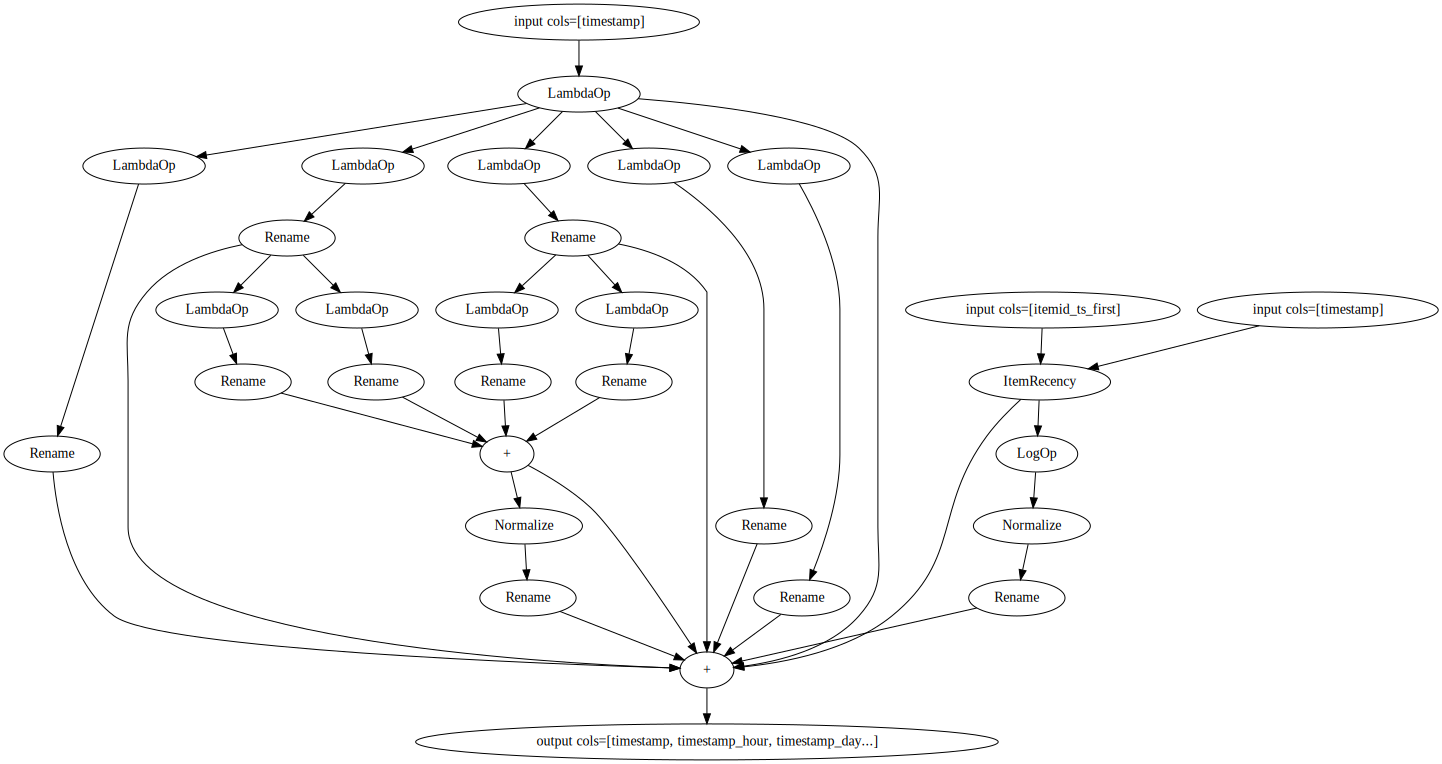

In [20]:
 time_features = (
    sessionTime + 
    sessionTime_hour +
    sessionTime_day + 
    sessionTime_month + 
    sessionTime_year +
    sessionTime_weekday +
    recency_features +
    recency_features_norm + 
    cycled_features +
    cycled_features_norm
)
time_features.graph

In [21]:
time_features.columns

['timestamp',
 'timestamp_hour',
 'timestamp_day',
 'timestamp_month',
 'timestamp_year',
 'timestamp_wd',
 'itemid_ts_first_age_days',
 'itemid_ts_first_age_days_norm',
 'timestamp_hour_sin',
 'timestamp_hour_cos',
 'timestamp_wd_sin',
 'timestamp_wd_cos',
 'timestamp_hour_sin_norm',
 'timestamp_hour_cos_norm',
 'timestamp_wd_sin_norm',
 'timestamp_wd_cos_norm']

Index(['timestamp', 'timestamp_hour', 'timestamp_day', 'timestamp_month',
       'timestamp_year', 'timestamp_wd', 'itemid_ts_first_age_days',
       'itemid_ts_first_age_days_norm', 'timestamp_hour_sin',
       'timestamp_hour_cos', 'timestamp_wd_sin', 'timestamp_wd_cos',
       'timestamp_hour_sin_norm', 'timestamp_hour_cos_norm',
       'timestamp_wd_sin_norm', 'timestamp_wd_cos_norm', 'session_id',
       'item_id', 'category'],
      dtype='object')

In [22]:
dataset = nvt.Dataset(gdf, cpu=False)

keys = ["session_id"]
# Define Groupby Workflow
groupby_features = (['item_id', 'category'] >> nvt.ops.Categorify()) + ['session_id']+ time_features >> nvt.ops.Groupby(
    groupby_cols=keys, 
    sort_cols=["timestamp"],
    aggs={
        "item_id": ["list"],
        "category": ["list"],
        "timestamp": ["list", "first", "last"],
        'timestamp_day': ["list"],
        'timestamp_hour': ["list"],
        'timestamp_month': ["list"],
        'timestamp_wd': ["list"],
        'itemid_ts_first_age_days': ["list"],
        'itemid_ts_first_age_days_norm': ["list"],
        'timestamp_hour_sin': ["list"],
        'timestamp_hour_sin_norm': ["list"],
        'timestamp_hour_cos': ["list"],
        'timestamp_hour_cos_norm': ["list"],
        'timestamp_wd_sin': ["list"],
        'timestamp_wd_sin_norm': ["list"],
        'timestamp_wd_cos': ["list"],
        'timestamp_wd_cos_norm': ["list"],
        
        },
    name_sep="-")

In [23]:
remaining_columns = [x for x in groupby_features.columns if x!= 'timestamp-first']
remaining_columns

['timestamp_wd_cos-list',
 'timestamp_hour_sin_norm-list',
 'itemid_ts_first_age_days_norm-list',
 'category-list',
 'timestamp-last',
 'itemid_ts_first_age_days-list',
 'timestamp_hour_cos-list',
 'timestamp_hour-list',
 'timestamp_wd_sin_norm-list',
 'timestamp_hour_sin-list',
 'timestamp_day-list',
 'timestamp_wd-list',
 'timestamp_wd_sin-list',
 'timestamp_hour_cos_norm-list',
 'timestamp-list',
 'item_id-list',
 'timestamp_month-list',
 'session_id',
 'timestamp_wd_cos_norm-list']

In [24]:
# calculate day index based on 'timestamp-first' column
day_index = ( (groupby_features - remaining_columns)  >> 
    nvt.ops.LambdaOp(lambda col: (col - col.min()).dt.days +1) >> 
    nvt.ops.Rename(f = lambda col: "day_index")
)

In [25]:
# This did not work
def datasettype(col):
    if col < 182 * 0.8:
        #value_generated = np.random.uniform(0.0,0.8)
        value_generated ='train'
    if 182 * 0.8 <= col < 182 * 0.9:
        #value_generated = np.random.uniform(0.8,0.9)
        value_generated ='valid'
    if col >= 182 * 0.9:
        #value_generated = np.random.uniform(0.9,1.0)
        value_generated ='testt'
    return value_generated

In [26]:
df = cudf.DataFrame([[20, 30]] * 3, columns=['A', 'B'])
# # df['A'].apply(lambda col: datasettype(col))

In [27]:
#does not work
#dataset_type = day_index >> (lambda col: 0.7 if (col < 182*0.8 ) else 0) >> nvt.ops.Rename(f = lambda col: "dataset_type")

In [28]:
day_idx_padded = day_index >> (lambda col: col.astype(str).str.pad(4,fillchar='0')) >> nvt.ops.Rename(f = lambda col: "day_idx_padded")

In [30]:
workflow = nvt.Workflow(groupby_features + day_index + day_idx_padded)

In [31]:
# workflow.column_group.columns

In [32]:
dataset = nvt.Dataset(gdf_merged, cpu=False)
workflow.fit(dataset)
new_gdf = workflow.transform(dataset).to_ddf().compute()

In [33]:
new_gdf.head(10)

,timestamp_wd_cos-list,timestamp_hour_sin_norm-list,itemid_ts_first_age_days_norm-list,category-list,timestamp-last,itemid_ts_first_age_days-list,timestamp_hour_cos-list,timestamp_hour-list,timestamp_wd_sin_norm-list,timestamp-first,...,timestamp_wd-list,timestamp_wd_sin-list,timestamp_hour_cos_norm-list,timestamp-list,item_id-list,timestamp_month-list,session_id,timestamp_wd_cos_norm-list,day_index,day_idx_padded
0,"[0.6234891, 0.6234891, 0.6234891, 0.6234891]","[0.8815278, 0.8815278, 0.8815278, 0.8815278]","[-1.2462238, -1.2462238, -1.3775287, -1.3775287]","[1, 1, 1, 1]",2014-04-07 10:57:00.306,"[6, 6, 5, 5]","[-0.8660256, -0.8660256, -0.8660256, -0.8660256]","[10, 10, 10, 10]","[1.1729306, 1.1729306, 1.1729306, 1.1729306]",2014-04-07 10:51:09.277,...,"[0, 0, 0, 0]","[0.7818321, 0.7818321, 0.7818321, 0.7818321]","[-0.9826049, -0.9826049, -0.9826049, -0.9826049]","[2014-04-07T10:51:09.277, 2014-04-07T10:54:09....","[2054, 2053, 2055, 9877]","[4, 4, 4, 4]",1,"[0.6580047, 0.6580047, 0.6580047, 0.6580047]",7,0007
1,"[0.6234891, 0.6234891, 0.6234891, 0.6234891, 0...","[-0.13563845, -0.13563845, -0.13563845, -0.135...","[-1.2462238, -1.2462238, -2.3133218, -2.313321...","[1, 1, 1, 1, 1, 1]",2014-04-07 14:02:36.889,"[6, 6, 1, 1, 1, 6]","[-0.96592575, -0.96592575, -0.96592575, -0.965...","[13, 13, 13, 13, 14, 14]","[1.1729306, 1.1729306, 1.1729306, 1.1729306, 1...",2014-04-07 13:56:37.614,...,"[0, 0, 0, 0, 0, 0]","[0.7818321, 0.7818321, 0.7818321, 0.7818321, 0...","[-1.1578012, -1.1578012, -1.1578012, -1.157801...","[2014-04-07T13:56:37.614, 2014-04-07T13:57:19....","[19449, 19449, 40789, 32517, 32523, 4854]","[4, 4, 4, 4, 4, 4]",2,"[0.6580047, 0.6580047, 0.6580047, 0.6580047, 0...",7,0007
2,"[-0.90096927, -0.90096927, -0.90096927]","[-0.13563845, -0.13563845, -0.13563845]","[-2.3133218, -2.3133218, -2.3133218]","[1, 1, 1]",2014-04-02 13:30:12.318,"[1, 1, 1]","[-0.96592575, -0.96592575, -0.96592575]","[13, 13, 13]","[0.6328651, 0.6328651, 0.6328651]",2014-04-02 13:17:46.940,...,"[2, 2, 2]","[0.43388295, 0.43388295, 0.43388295]","[-1.1578012, -1.1578012, -1.1578012]","[2014-04-02T13:17:46.940, 2014-04-02T13:26:02....","[28990, 35311, 43179]","[4, 4, 4]",3,"[-1.3648345, -1.3648345, -1.3648345]",2,0002
3,"[0.6234891, 0.6234891]","[0.21129768, 0.21129768]","[-1.2462238, -1.2462238]","[1, 1]",2014-04-07 12:26:25.416,"[6, 6]","[-1.0, -1.0]","[12, 12]","[1.1729306, 1.1729306]",2014-04-07 12:09:10.948,...,"[0, 0]","[0.7818321, 0.7818321]","[-1.2175578, -1.2175578]","[2014-04-07T12:09:10.948, 2014-04-07T12:26:25....","[44326, 26362]","[4, 4]",4,"[0.6580047, 0.6580047]",7,0007
4,"[1.0, 1.0]","[-0.94957423, -1.0834864]","[-1.3775287, -1.3775287]","[1, 1]",2014-04-06 17:02:26.976,"[5, 5]","[-0.4999995, -0.25881854]","[16, 17]","[-0.040579867, -0.040579867]",2014-04-06 16:58:20.848,...,"[6, 6]","[1.1285199e-06, 1.1285199e-06]","[-0.3406998, 0.08226263]","[2014-04-06T16:58:20.848, 2014-04-06T17:02:26....","[25633, 41161]","[4, 4]",6,"[1.1576058, 1.1576058]",6,0006
5,"[-0.90096927, -0.90096927]","[1.5517582, 1.5517582]","[-2.3133218, -2.3133218]","[1, 1]",2014-04-02 06:39:05.854,"[1, 1]","[-2.8212997e-07, -2.8212997e-07]","[6, 6]","[0.6328651, 0.6328651]",2014-04-02 06:38:53.104,...,"[2, 2]","[0.43388295, 0.43388295]","[0.5361559, 0.5361559]","[2014-04-02T06:38:53.104, 2014-04-02T06:39:05....","[41233, 41185]","[4, 4]",7,"[-1.3648345, -1.3648345]",2,0002
6,"[1.0, 1.0]","[1.3721704, 1.3721704]","[-1.3775287, -1.3775287]","[1, 1]",2014-04-06 08:52:12.647,"[5, 5]","[-0.5000003, -0.5000003]","[8, 8]","[-0.040579867, -0.040579867]",2014-04-06 08:49:58.728,...,"[6, 6]","[1.1285199e-06, 1.1285199e-06]","[-0.34070122, -0.34070122]","[2014-04-06T08:49:58.728, 2014-04-06T08:52:12....","[45038, 45038]","[4, 4]",8,"[1.1576058, 1.1576058]",6,0006
7,"[1.0, 1.0, 1.0]","[0.55823445, 0.55823445, 0.55823445]","[-1.3775287, -1.3775287, -1.3775287]","[1, 1, 1]",2014-04-06 11:29:13.479,"[5, 5, 5]","[-0.96592593, -0.96592593, -0.96592593]","[11, 11, 11]","[-0.040579867

In [34]:
new_gdf['day_index'].min(), new_gdf['day_index'].max(), new_gdf['day_idx_padded'].min(), new_gdf['day_idx_padded'].max()

(1, 182, '0001', '0182')

In [35]:
# Convert to a Datset and write out hive-partitioned data to disk
path ='./output_day/'
nvt.Dataset(new_gdf).to_parquet(path, partition_on=['day_idx_padded'])

In [36]:
#test one output

day_0 = cudf.read_parquet('/workspace/yoochoose-data/output_day/day_idx_padded=0001/part.0.parquet')

In [37]:
day_0

,timestamp_wd_cos-list,timestamp_hour_sin_norm-list,itemid_ts_first_age_days_norm-list,category-list,timestamp-last,itemid_ts_first_age_days-list,timestamp_hour_cos-list,timestamp_hour-list,timestamp_wd_sin_norm-list,timestamp-first,...,timestamp_day-list,timestamp_wd-list,timestamp_wd_sin-list,timestamp_hour_cos_norm-list,timestamp-list,item_id-list,timestamp_month-list,session_id,timestamp_wd_cos_norm-list,day_index
0,"[-0.22252177, -0.22252177, -0.22252177]","[0.8815278, 0.8815278, 0.8815278]","[-2.9037416, -2.9037416, -2.9037416]","[1, 1, 1]",2014-04-01 10:12:36.482,"[0, 0, 0]","[-0.8660256, -0.8660256, -0.8660256]","[10, 10, 10]","[1.4726418, 1.4726418, 1.4726418]",2014-04-01 10:09:01.362,...,"[1, 1, 1]","[1, 1, 1]","[0.9749277, 0.9749277, 0.9749277]","[-0.9826049, -0.9826049, -0.9826049]","[2014-04-01T10:09:01.362, 2014-04-01T10:11:14....","[9918, 11196, 9918]","[4, 4, 4]",14,"[-0.4645868, -0.4645868, -0.4645868]",1
1,"[-0.22252177, -0.22252177]","[1.5060833, 1.5060833]","[-2.9037416, -2.9037416]","[1, 1]",2014-04-01 05:26:32.156,"[0, 0]","[0.25881875, 0.25881875]","[5, 5]","[1.4726418, 1.4726418]",2014-04-01 05:26:12.539,...,"[1, 1]","[1, 1]","[0.9749277, 0.9749277]","[0.9900504, 0.9900504]","[2014-04-01T05:26:12.539, 2014-04-01T05:26:32....","[9918, 9918]","[4, 4]",18,"[-0.4645868, -0.4645868]",1
2,"[-0.22252177, -0.22252177, -0.22252177, -0.222...","[-0.9495733, -0.9495733, -0.9495733, -0.9495733]","[-2.9037416, -2.9037416, -2.9037416, -2.9037416]","[1, 1, 1, 1]",2014-04-01 20:54:54.651,"[0, 0, 0, 0]","[0.5000007, 0.5000007, 0.5000007, 0.5000007]","[20, 20, 20, 20]","[1.4726418, 1.4726418, 1.4726418, 1.4726418]",2014-04-01 20:52:12.357,...,"[1, 1, 1, 1]","[1, 1, 1, 1]","[0.9749277, 0.9749277, 0.9749277, 0.9749277]","[1.4130145, 1.4130145, 1.4130145, 1.4130145]","[2014-04-01T20:52:12.357, 2014-04-01T20:52:13....","[7832, 7832, 13821, 13821]","[4, 4, 4, 4]",19,"[-0.4645868, -0.4645868, -0.4645868, -0.4645868]",1
3,"[-0.22252177, -0.22252177]","[1.3721704, 1.3721704]","[-2.9037416, -2.9037416]","[1, 1]",2014-04-01 08:38:17.758,"[0, 0]","[-0.5000003, -0.5000003]","[8, 8]","[1.4726418, 1.4726418]",2014-04-01 08:36:04.146,...,"[1, 1]","[1, 1]","[0.9749277, 0.9749277]","[-0.34070122, -0.34070122]","[2014-04-01T08:36:04.146, 2014-04-01T08:38:17....","[2426, 2426]","[4, 4]",31,"[-0.4645868, -0.4645868]",1
4,"[-0.22252177, -0.22252177]","[-0.7365494, -0.7365494]","[-2.9037416, -2.9037416]","[1, 1]",2014-04-01 21:21:44.551,"[0, 0]","[0.707107, 0.707107]","[21, 21]","[1.4726418, 1.4726418]",2014-04-01 21:21:00.460,...,"[1, 1]","[1, 1]","[0.9749277, 0.9749277]","[1.7762198, 1.7762198]","[2014-04-01T21:21:00.460, 2014-04-01T21:21:44....","[22514, 21519]","[4, 4]",39,"[-0.4645868, -0.4645868]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56035,"[-0.22252177, -0.22252177, -0.22252177, -0.222...","[-1.0834862, -1.0834862, -1.0834862, -1.083486...","[-2.9037416, -2.9037416, -2.9037416, -2.903741...","[1, 1, 1, 1, 1, 1, 1]",2014-04-01 19:30:03.394,"[0, 0, 0, 0, 0, 0, 0]","[0.25881946, 0.25881946, 0.25881946, 0.2588194...","[19, 19, 19, 19, 19, 19, 19]","[1.4726418, 1.4726418, 1.4726418, 1.4726418, 1...",2014-04-01 19:25:50.288,...,"[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[0.9900516, 0.9900516, 0.9900516, 0.9900516, 0...","[2014-04-01T19:25:50.288, 2014-04-01T19:26:20....","[29024, 28987, 29024, 28986, 29024, 28987, 28987]","[4, 4, 4, 4, 4, 4, 4]",494917,"[-0.4645868, -0.4645868, -0.4645868, -0.464586...",1
56036,"[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.21129768, 0.21129768, 0.21129768, 0.2112976...","[-2.9037416, -2.9037416, -2.9037416, -2.903741...","[1, 1, 1, 1, 1]",2014-04-01 12:45:38.817,"[0, 0, 0, 0, 0]","[-1.0, -1.0, -1.0, -1.0, -1.0]","[12, 12, 12, 12, 12]","[1.4726418, 1.4726418, 1.4726418, 1.4726418, 1...",2014-04-01 12:39:57.736,...,"[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[0.9749277, 0.9749277, 0.9749277, 0.9749